In [1]:
import numpy as np

from keras.models import model_from_json, load_model
from keras.models import Model
from keras.layers.core import Dense, Flatten
from keras.layers import Convolution2D, merge, MaxPooling2D, Input, Add, Concatenate
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

import tensorflow as tf

from collections import deque
import random

from latticeEnv import Lattice, Domain, TPD
import topy

Using TensorFlow backend.


In [2]:
# Using Deep Deterministic Policy Gradient

# Code inspired by: https://github.com/yanpanlau/DDPG-Keras-Torcs

class ActorNetwork(object):
    
    def __init__(self, sess, state_shape, action_size, LR, TAU):
        self.sess = sess
        self.LR = LR
        self.TAU = TAU # Hyperparameter for target network update
        
        from keras import backend as K
        K.set_session(self.sess)
        
        self.model, self.weights, self.state = self.actor_net(state_shape, action_size)
        self.target_model, self.target_weights, self.target_state = self.actor_net(state_shape, action_size)
        self.action_gradient = tf.placeholder(tf.float32, [None, action_size])
        self.params_grad = tf.gradients(self.model.outputs, self.weights, -self.action_gradient)
        grads = zip(self.params_grad, self.weights)
        self.optimize = tf.train.AdamOptimizer(self.LR).apply_gradients(grads)
        self.sess.run(tf.global_variables_initializer())
        
    def train(self, states, action_grads):
        fd = {i: d for i, d in zip(self.state, states)}
        fd[self.action_gradient] = action_grads
        self.sess.run(self.optimize, feed_dict=fd)
        
    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU) * actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)
        
    def actor_net(self, state_shape, action_size):
        """
        Actor Network: State to Action
        
        State consists of four images - shape, x-displacement, y-displacement, compliance
        Action increases/decreases parameters of lattice cells (currently only single parameter for each cell)
        """
        
        input1 = Input(shape=state_shape[0])
        feat1 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input1)
        feat1 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat1)
        feat1 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat1)
        feat1 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat1)
        feat1 = Flatten()(feat1)
        feat1 = Dense(256, activation='relu')(feat1)
        
        input2 = Input(shape=state_shape[1])
        feat2 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input2)
        feat2 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat2)
        feat2 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat2)
        feat2 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat2)
        feat2 = Flatten()(feat2)
        feat2 = Dense(256, activation='relu')(feat2)
        
        input3 = Input(shape=state_shape[2])
        feat3 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input3)
        feat3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat3)
        feat3 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat3)
        feat3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat3)
        feat3 = Flatten()(feat3)
        feat3 = Dense(256, activation='relu')(feat3)
        
        input4 = Input(shape=state_shape[3])
        feat4 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input4)
        feat4 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat4)
        feat4 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat4)
        feat4 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat4)
        feat4 = Flatten()(feat4)
        feat4 = Dense(256, activation='relu')(feat4)
        
        merge_feat = Concatenate()([feat1, feat2, feat3, feat4])
        
        out = Dense(action_size, activation='tanh')(merge_feat)
        
        state = [input1, input2, input3, input4]
        model = Model(inputs=state, outputs=out)
        
        return model, model.trainable_weights, state

In [3]:
class CriticNetwork(object):
    
    def __init__(self, sess, state_shape, action_size, LR, TAU):
        self.sess = sess
        self.LR = LR
        self.TAU = TAU # Hyperparameter for target network update
        
        from keras import backend as K
        K.set_session(self.sess)
        
        self.model, self.action, self.state = self.critic_net(state_shape, action_size)
        self.target_model, self.target_action, self.target_state = self.critic_net(state_shape, action_size)
        self.action_grads = tf.gradients(self.model.outputs, self.action)
        self.sess.run(tf.global_variables_initializer())
        
    def gradients(self, states, actions):
        fd = {i: d for i, d in zip(self.state, states)}
        fd[self.action] = actions
        return self.sess.run(self.action_grads,
                             feed_dict=fd)
        
    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU) * critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)
        
    def critic_net(self, state_shape, action_size):
        """
        Critic Network: State and Action to Q-value
        
        State consists of four images - shape, x-displacement, y-displacement, compliance
        Action increases/decreases parameters of lattice cells (currently only single parameter for each cell)
        Q-value estimates the quality of State and Action pair
        """
        
        input1 = Input(shape=state_shape[0])
        feat1 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input1)
        feat1 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat1)
        feat1 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat1)
        feat1 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat1)
        feat1 = Flatten()(feat1)
        feat1 = Dense(256, activation='relu')(feat1)
        
        input2 = Input(shape=state_shape[1])
        feat2 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input2)
        feat2 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat2)
        feat2 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat2)
        feat2 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat2)
        feat2 = Flatten()(feat2)
        feat2 = Dense(256, activation='relu')(feat2)
        
        input3 = Input(shape=state_shape[2])
        feat3 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input3)
        feat3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat3)
        feat3 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat3)
        feat3 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat3)
        feat3 = Flatten()(feat3)
        feat3 = Dense(256, activation='relu')(feat3)
        
        input4 = Input(shape=state_shape[3])
        feat4 = Convolution2D(16, (5, 5), padding='same', activation='relu')(input4)
        feat4 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat4)
        feat4 = Convolution2D(32, (5, 5), padding='same', activation='relu')(feat4)
        feat4 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(feat4)
        feat4 = Flatten()(feat4)
        feat4 = Dense(256, activation='relu')(feat4)
        
        state_feat = Concatenate()([feat1, feat2, feat3, feat4])
        
        action = Input(shape=[action_size])
        action_feat = Dense(256*4, activation='linear')(action)
        
        combined_feat = Add()([state_feat, action_feat])
        combined_feat = Dense(256, activation='relu')(combined_feat)
        
        out = Dense(1, activation='linear')(combined_feat)
        
        state = [input1, input2, input3, input4]
        model = Model(inputs=state + [action], outputs=out)
        
        model.compile(loss='mean_squared_error', optimizer=Adam(lr = self.LR))
        
        return model, action, state

In [4]:
class ReplayBuffer(object):

    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.num_experiences = 0
        self.buffer = deque()

    def getBatch(self, batch_size):
        # Randomly sample batch_size examples
        if self.num_experiences < batch_size:
            return random.sample(self.buffer, self.num_experiences)
        else:
            return random.sample(self.buffer, batch_size)

    def size(self):
        return self.buffer_size

    def add(self, state, action, reward, new_state):
        experience = (state, action, reward, new_state)
        if self.num_experiences < self.buffer_size:
            self.buffer.append(experience)
            self.num_experiences += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def count(self):
        # if buffer is full, return buffer size
        # otherwise, return experience counter
        return self.num_experiences

    def erase(self):
        self.buffer = deque()
        self.num_experiences = 0

In [5]:
BUFFER_SIZE = 16
BATCH_SIZE = 4
GAMMA = 0.99
TAU = 0.001     #Target Network HyperParameters
LRA = 0.0001    #Learning rate for Actor
LRC = 0.001     #Lerning rate for Critic
EXPLORE = 100000. ## TODO ##

np.random.seed(0)

episode_count = 2
max_steps = 16
fea_step = 8 # perform FEA computation after these many steps
epsilon = 1. ## TODO ##

#Tensorflow GPU optimization # TODO currently running on CPU
config = tf.ConfigProto()
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

# Initialize Lattice environment in the domain
domainSz = np.array([128, 96])
cellSz = np.array([16, 16]) # ensure domainSz is divisible by cellSz
env = Lattice(domainSz, cellSz) ## TODO ## Just initialize variable
state_shapes = env.state_shapes
action_size = env.action_size

actor = ActorNetwork(sess, state_shapes, action_size, LRA, TAU)
critic = CriticNetwork(sess, state_shapes, action_size, LRC, TAU)
buff = ReplayBuffer(BUFFER_SIZE)

# TODO load saved weights

for i in range(episode_count):
    print("Episode: " + str(i))
    
    domain = env.reset() ## TODO ## return random initial state as object of domain class
    s_t = [domain.bin_img, domain.dispX, domain.dispY, domain.comp] # check to see if batch dim added correctly
    
    total_reward = 0.
    for j in range(max_steps):
        print("Step: " + str(j))
        loss = 0
        
        a_t = actor.model.predict([e[np.newaxis, :] for e in s_t])
        
        # TODO add noise to action
        
        domain, r_t = env.step(a_t[0], np.mod(j, fea_step) == 0) ## TODO ## take action on current state
        s_t1 = [domain.bin_img, domain.dispX, domain.dispY, domain.comp]
        
        buff.add(s_t, a_t[0], r_t, s_t1)
        
        batch = buff.getBatch(BATCH_SIZE)
        states = [np.asarray([e[0][k] for e in batch]) for k in range(4)]
        actions = np.asarray([e[1] for e in batch])
        rewards = np.asarray([e[2] for e in batch])
        new_states = [np.asarray([e[3][k] for e in batch]) for k in range(4)]
        q_t = np.asarray([e[2] for e in batch])
        
        target_q_values = critic.target_model.predict(new_states + [actor.target_model.predict(new_states)])
        
        q_t = rewards[:, np.newaxis] + GAMMA*target_q_values
        
        ## TODO ## check training vs testing
        loss += critic.model.train_on_batch(states + [actions], q_t)
        temp_actions = actor.model.predict(states) ## TODO ## why can't just use actions? noise?
        grads = critic.gradients(states, temp_actions)[0]
        actor.train(states, grads)
        actor.target_train()
        critic.target_train()
        
        total_reward += r_t
        s_t = s_t1
        
    print("Total reward: " + str(total_reward) + ", Loss: " + str(loss))
    print("")

env.end() ## TODO ## End the run - save the resulting lattice?
print("Fin.")

Episode: 0
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Total reward: -0.0613944352881, Loss: 38.6196022034

Episode: 1
Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Total reward: -0.0930826397422, Loss: 0.0294322855771

Fin.


In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

In [7]:
domain.bin_img.shape

(128, 96, 1)

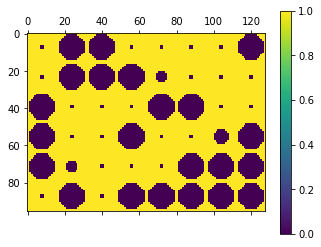

In [8]:
plt.matshow(domain.bin_img[:, :, 0].T)
plt.colorbar()
plt.show()

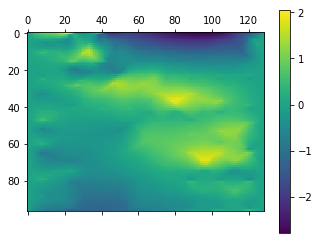

In [9]:
plt.matshow(domain.dispX[:, :, 0].T)
plt.colorbar()
plt.show()

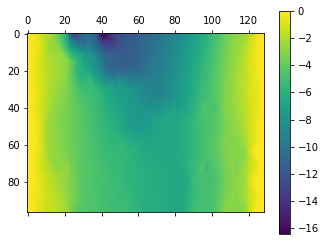

In [10]:
plt.matshow(domain.dispY[:, :, 0].T)
plt.colorbar()
plt.show()

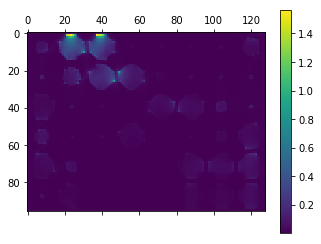

In [14]:
plt.matshow(domain.comp[:, :, 0].T)
plt.colorbar()
plt.show()